In [331]:
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from more_itertools import chunked

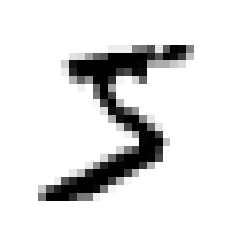

In [520]:
mntrain = MNIST('../samples')

img_tr,lbl_tr = mntrain.load_training()
img_ts,lbl_ts = mntrain.load_testing()
img_size = 28 # 28x28 pixels

def display_image(img):
    plt.imshow(np.array(img).reshape(img_size,img_size), cmap=plt.cm.binary)
    plt.gcf().axes[0].set_axis_off()
    plt.show()

display_image(img_tr[0])

In [506]:
def activation(x, d=False, fn = 'sigmoid'):
    """Activation function for the neural network.
    Args:
        x (np.array): Input to the activation function.
        d (bool): If True, return the derivative of the activation function.
        fn (str): The activation function to use. Options are 'sigmoid', 'tanh', 'relu', 'leaky_relu', 'softmax', and 'linear'.
    
    Returns:
        np.array: The output of the activation function.
    """
    if fn == 'sigmoid':
        if d:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))
    if fn == 'tanh':
        if d:
            return 1 - np.tanh(x)**2
        return np.tanh(x)
    if fn == 'relu':
        if d:
            return np.where(x > 0, 1, 0)
        return np.maximum(0, x)
    if fn == 'leaky_relu':
        if d:
            return np.where(x > 0, 1, 0.01)
        return np.maximum(0.01*x, x)
    if fn == 'softmax':
        if d:
            return x * (1 - x)
        return np.exp(x) / np.sum(np.exp(x), axis=0)
    if fn == 'linear':
        if d:
            return 1
        return x

In [508]:
class Layer:
    """A layer of neuron nodes.

    Attributes:
        length (int): The number of nodes in the layer.
        nodes (np.array): The nodes in the layer.
        values (np.array): The values of the nodes in the layer.
    """
    
    
    def __init__(self, length):
        self.length = length
        self.nodes = np.zeros(length)
        
    def __str__(self):
        return "Layer: length: %d" % (self.length)
    def __repr__(self):
        return self.__str__()
    def __getitem__(self, index):
        return self.nodes[index]
    def __setitem__(self, index, value):
        self.nodes[index].value = value
    def __iter__(self):
        return iter(self.nodes)
    def __len__(self):
        return len(self.nodes)
    def __contains__(self, item):
        return item in self.nodes
    
    def get_values(self):
        return self.nodes
    def set_values(self, values):
        self.nodes = np.array(values)
    values = property(get_values, set_values)

    
class Neurons:
    """A connection between two layers of neuron nodes.
    
    Attributes:
        input (Layer): The input layer.
        output (Layer): The output layer.
        weights (np.array): The weights of the connections.
        biases (np.array): The biases of the connections.
    """
    
    
    
    def __init__(self, input: Layer, output: Layer):
        self.input = input
        self.output = output
        self.weights = np.random.rand(len(output), len(input))*2-1
        self.biases = np.random.rand(len(output))*2-1

    def __str__(self):
        return "Layer_Connection: layer1: %s, layer2: %s, weights: %s, biases: %s" % (len(self.input), len(self.output), self.weights.shape, self.biases.shape)
    def __repr__(self):
        return self.__str__()
    def __getitem__(self, index):
        return self.weights[index]
    def __setitem__(self, index, value):
        self.weights[index] = value
    def __iter__(self):
        return iter(self.weights)
    def __len__(self):
        return self.weights.shape[0] * self.weights.shape[1]
    def __contains__(self, layer):
        return layer in (self.input, self.output)


class Neural_Network:
    """A neural network.
    
    Attributes:
        input_size (int): The number of inputs to the network.
        output_size (int): The number of outputs from the network.
        hidden_size (int): The number of nodes in each hidden layer.
        hidden_layers (int): The number of hidden layers.
        layers (list): The layers of the network.
        neurons (list): The connections between the layers of the network.
        
    Methods:
        feed_forward (np.array): Feed forward the inputs through the network.
        back_propagate (np.array): Back propagate the errors through the network.
        train (np.array): Train the network.
        test (np.array): Test the network.
    """
    
    
    
    
    def __init__(self, output_size,hidden_size, hidden_layers=1):
        self.input_size = 28*28 # 28x28 pixels
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.layers = [Layer(self.input_size)]
        self.layers.extend([Layer(hidden_size) for _ in range(hidden_layers)])
        self.layers.append(Layer(output_size))
        
        self.neurons = [Neurons(self.layers[i], self.layers[i+1]) for i in range(len(self.layers)-1)][::-1]
    
    def __str__(self):
        return "Neural_Network: input_size: %d, hidden_size: %d, output_size: %d, hidden_layers: %d, layers: %s, connections: %s" % (self.input_size, self.hidden_size, self.output_size, len(self.layers)-2, self.layers, self.neurons)
    def __repr__(self):
        return self.__str__()
        
    def output_vector(self):
        return self.layers[-1].values
    
    def output(self):
        return np.argmax(self.output_vector())
    
    def feed_forward(self, image, fn='sigmoid'):
        """Feed forward the inputs through the network.
        
        Args:
            image (np.array): The image to feed forward.
            fn (str): The activation function to use.
            
        Returns:
            None
        """
        self.layers[0].values = np.array(image)/256 #normalize pixel values
        neurs = self.neurons[::-1]
        for depth, layer in enumerate(self.layers[1:]):
            layer.values = activation(np.dot(neurs[depth].weights, self.layers[depth]) + neurs[depth].biases, fn=fn)
            

    def back_propagate(self, images, labels, factor, fn='sigmoid'):
        """Back propagate the errors through the network as a batch.
        
        Args:
            images (np.array): The images to train on.
            labels (np.array): The labels of the images.
            factor (float): The factor to multiply the gradients by.
            fn (str): The activation function to use.
            
        Returns:
            None
        """
        label_arrays = [np.zeros(self.output_size) for _ in range(len(labels))]
        for i,label in enumerate(labels): #convert labels to arrays
            label_arrays[i][label] = 1
            
        total_nabla_w = [np.zeros(neuron.weights.shape) for neuron in self.neurons] #initialize gradients
        total_nabla_b = [np.zeros(neuron.biases.shape) for neuron in self.neurons] #initialize biases
        for i in range(len(images)): #calculate gradients
            nabla_w, nabla_b = self.back_propagate_single(images[i], label_arrays[i], fn=fn)
            for j in range(len(nabla_w)):
                total_nabla_w[j] += nabla_w[j]
                total_nabla_b[j] += nabla_b[j]
            
        for i in range(len(self.neurons)): #update weights and biases
            self.neurons[i].weights += factor * total_nabla_w[i]/len(images)
            self.neurons[i].biases += factor * total_nabla_b[i]/len(images)
        
    def back_propagate_single(self, image, label, fn='sigmoid'):
        """Back propagation helper function for the errors through the network for a single image.
        
        Args:
            image (np.array): The image to train on.
            label (np.array): The label of the image.
            fn (str): The activation function to use.
        
        Returns:
            nabla_w (list): The gradients of the weights.
            nabla_b (list): The gradients of the biases.
        """
        self.feed_forward(image, fn=fn)
        nabla_w = []
        nabla_b = []
        for i in range(len(self.neurons)):
            neuron = self.neurons[i]
            if i == 0: #output layer 
                delta = (np.array(neuron.output.values) - label) * activation(np.array(neuron.output.values), fn=fn, d=True)
            else: #hidden layers
                delta = np.matmul(self.neurons[i-1].weights.T, delta) * activation(np.array(neuron.output.values), fn=fn, d=True)
            delta_w = np.outer(delta, neuron.input.values)
            nabla_w.append(delta_w)
            nabla_b.append(delta)
        return nabla_w, nabla_b


    def test(self, images, labels, fn='sigmoid'):
        """Test the network.
        
        Args:
            images (np.array): The images to test on.
            labels (np.array): The labels of the images.
            fn (str): The activation function to use.
        
        Returns:
            correct/len(images) (float): The accuracy of the network.
        """
        correct = 0
        for i in trange(len(images)):
            self.feed_forward(images[i], fn=fn)
            if self.output() == labels[i]:
                correct += 1
                print("Correct: " % (correct, labels[i], self.output()))
        return correct/len(images)

              
    def train(self, images, labels, epochs=1, factor=0.1,batch_size=1, fn='sigmoid'):
        """Train the network.
        
        Args:
            images (np.array): The images to train on.
            labels (np.array): The labels of the images.
            epochs (int): The number of epochs to train for.
            factor (float): The factor to multiply the gradients by.
            batch_size (int): The size of the batches to train on.
            fn (str): The activation function to use.
            
        Returns:
            None
        """
        img_lbls = list(zip(images,labels))
        for _ in trange(epochs):
            np.random.shuffle(img_lbls) #shuffle the images
            batches = chunked(img_lbls, batch_size) #split into batches
            for batch in tqdm(batches, leave=False, desc="Epoch", total = len(images)//batch_size): #train on batches
                batch_images = [image for image,_ in batch]
                batch_labels = [label for _,label in batch]
                self.back_propagate(batch_images, batch_labels, factor,fn=fn)

In [509]:
nn = Neural_Network(784, 10, 16, 1)

In [521]:
nn.train(img_tr,lbl_tr, 50, 0.2, 1, fn='relu')
nn.train(img_tr,lbl_tr, 50, 0.3, 100, fn='relu')
nn.train(img_tr,lbl_tr, 50, 0.4, 1000, fn='relu')

 37%|███▋      | 37/100 [14:10<24:21, 23.20s/it]

In [1]:
nn.test(img_ts,lbl_ts, fn='relu')

NameError: name 'nn' is not defined